# Configurations

### Import

In [1]:
import os
import joblib

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd; pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import holidays
from tqdm import tqdm

import torch
import pytorch_forecasting as pf
from PIL import Image
from torchvision import transforms
from transformers import SwinModel
device = torch.device("cuda")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Params

In [2]:
# General params
random_state = 0

### Read

In [3]:
df_raw = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
df_article = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})
df_article = df_article[["article_id"] + [col for col in df_article.columns if "name" in col]]

### Preprocess

In [4]:
holiday = holidays.KR()

def to_cyclic(df, col_name, cycle):
    df = df.copy()
    sin = np.sin(2 * np.pi * df.values / cycle)
    cos = np.cos(2 * np.pi * df.values / cycle)
    df = pd.DataFrame({"sin":sin, "cos":cos})
    return df

In [5]:
df_prep = df_raw.copy()

# Make daily sales
df_prep = df_prep.copy()
df_prep = df_prep.groupby(["article_id", "t_dat"], as_index=False).agg(sales=("customer_id", "count"), price=("price","mean"))
df_prep["sales"] = df_prep["sales"].astype(float)
df_prep["size"] = df_prep.groupby("article_id").transform("size")

# Explode time
time_idx_li = []
date_range = pd.date_range(df_prep["t_dat"].min(), df_prep["t_dat"].max(), freq="d")

for prod in tqdm(df_prep["article_id"].unique()):
    df = pd.DataFrame()
    df["t_dat"] = date_range
    df["article_id"] = prod
    # df["time_idx"] = df.groupby("article_id")["t_dat"].cumcount()
    time_idx_li.append(df)
time_idx = pd.concat(time_idx_li)
df_prep = pd.merge(df_prep, time_idx, on=["article_id", "t_dat"], how="right")
df_prep["sales"] = df_prep["sales"].fillna(0)
df_prep["price"] = df_prep["price"].fillna(method="ffill")
df_prep["size"] = df_prep["size"].fillna(method="ffill")

# Add week, month, year, holidays
# df_prep["holiday"] = df_prep["t_dat"].apply(lambda x: 1 if x in holiday else 0)
df_prep["year"] = df_prep["t_dat"].dt.year
df_prep["month"] = df_prep["t_dat"].dt.month
df_prep["week"] = df_prep["t_dat"].dt.isocalendar().week

# Agg by week
df_prep.loc[(df_prep["week"] == 1) & (df_prep["month"] == 12), "year"] = df_prep["year"] + 1
df_prep.loc[(df_prep["week"] > 25) & (df_prep["month"] == 1), "year"] = df_prep["year"] - 1
df_prep = df_prep.drop("month", axis=1)

df_prep["year_week"] = df_prep["year"].astype(str) + df_prep["week"].astype(str).str.zfill(2)
df_prep = df_prep.groupby(["article_id", "year_week"], as_index=False).agg(year=("year","max"), week=("week","max"), sales=("sales","sum"), price=("price","mean"), size=("size","max"))
df_prep[["week_sin", "week_cos"]] = to_cyclic(df_prep["week"], "week", 52)

# Generate image path
df_prep["img_path"] = df_prep["article_id"].apply(lambda x: f'../HnM/images/{x[:3]}/{x}.jpg') # Generate image path
df_prep["is_valid"] = df_prep["img_path"].apply(lambda x: 1 if os.path.isfile(x) else 0) # Check whether the article has corresponding image file
df_prep = df_prep[df_prep["is_valid"] == 1] # Valid if having corresponding image

# Add time idx
df_prep["time_idx"] = df_prep.groupby("article_id").cumcount()

100%|██████████| 104547/104547 [00:35<00:00, 2911.22it/s]


# Dataset

In [3]:
df_prep["-1"] = df_prep.groupby("article_id")["time_idx"].shift(-1).dropna()
df_prep[df_prep["-1"] - df_prep["time_idx"] > 1]
df_prep = df_prep.drop("-1", axis=1)

import joblib
joblib.dump(df_prep, "df_prep.pkl")

NameError: name 'df_prep' is not defined

In [3]:
df_prep = joblib.load("df_prep.pkl")
train = df_prep.copy()
train = train[train["size"] >= 100].drop("size", axis=1)

encoder = LabelEncoder()
train["img_path"] = encoder.fit_transform(train["img_path"]) + 1

In [4]:
train["-1"] = train.groupby("article_id")["time_idx"].shift(-1).dropna()
train[train["-1"] - train["time_idx"] > 1]

,article_id,year_week,year,week,sales,price,week_sin,week_cos,img_path,is_valid,time_idx,-1


In [5]:
max_prediction_length = 8 # a whole year
max_encoder_length = 52

# For training/evaluation splits
training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020

# Create training set
training_dataset = pf.TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="sales",
    group_ids=["article_id"], # static covariates
    min_encoder_length=max_encoder_length//2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_reals = ["img_path"],
    time_varying_known_reals=[
        "time_idx", 'week_cos', 'week_sin', "year"],
    time_varying_unknown_reals=['sales', "price"],
    target_normalizer=pf.data.GroupNormalizer(
        groups=["article_id"], transformation="softplus"
    ),  # use softplus transformation and normalize by group
    lags={'sales': [26, 52]}, # add lagged values of target variable
    scalers = {"img_path":None},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation_dataset = pf.TimeSeriesDataSet.from_dataset(training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
                                            train, # data from which new dataset will be generated
                                            predict=True, # predict the decoder length on the last entries in the time index
                                            stop_randomization=True)

# create training and validation dataloaders for model
batch_size = 128
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

# print(len(train_dataloader))
# next(iter(train_dataloader))

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1281: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 5502 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__article_id': '0181448103'}, {'__group_id__article_id': '0188183015'}, {'__group_id__article_id': '0189616038'}, {'__group_id__article_id': '0212629051'}, {'__group_id__article_id': '0217727018'}, {'__group_id__article_id': '0234421002'}, {'__group_id__article_id': '0266875022'}, {'__group_id__article_id': '0268305007'}, {'__group_id__article_id': '0270381013'}, {'__group_id__article_id': '0278811010'}]
  warnings.warn(
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1281: UserWarning: Min encoder length and/or min_prediction_i

# Train

In [6]:
class ImgTransformer(torch.nn.Module):
    def __init__(self, imgpath_encoder, hidden_size):
        super().__init__()
        self.imgpath_encoder = imgpath_encoder
        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]) # Transform image based on ImageNet standard

        self.swin_transformer = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224") # Get pre-trained SwinTransformer
        self.linear = torch.nn.Linear(self.swin_transformer.config.hidden_size*49, hidden_size)

    def forward(self, x):
        x = (x-1).type(torch.int)
        path_li = self.imgpath_encoder.inverse_transform(x.cpu().ravel())
        img_li = []
        for path in path_li:
            img = self.transform(Image.open(path).convert("RGB"))
            img_li.append(img)
        img_tensor = torch.stack(img_li, dim=0)
        res = self.swin_transformer(img_tensor.to(device)).last_hidden_state.reshape(x.shape[0], -1)
        res = torch.nn.ReLU()(self.linear(res))

        return res

In [7]:
"""
The temporal fusion transformer is a powerful predictive model for forecasting timeseries
"""
from copy import copy
from typing import Dict, List, Tuple, Union

from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn
from torchmetrics import Metric as LightningMetric

from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, MAPE, MASE, RMSE, SMAPE, MultiHorizonMetric, MultiLoss, QuantileLoss
from pytorch_forecasting.models.base_model import BaseModelWithCovariates
from pytorch_forecasting.models.nn import LSTM, MultiEmbedding
from pytorch_forecasting.models.temporal_fusion_transformer.sub_modules import (
    AddNorm,
    GateAddNorm,
    GatedLinearUnit,
    GatedResidualNetwork,
    InterpretableMultiHeadAttention,
    VariableSelectionNetwork,
)
from pytorch_forecasting.utils import create_mask, detach, integer_histogram, masked_op, padded_stack, to_list


class TemporalFusionTransformer(BaseModelWithCovariates):
    def __init__(
        self,
        hidden_size: int = 16,
        lstm_layers: int = 1,
        dropout: float = 0.1,
        output_size: Union[int, List[int]] = 7,
        loss: MultiHorizonMetric = None,
        attention_head_size: int = 4,
        max_encoder_length: int = 10,
        static_categoricals: List[str] = [],
        static_reals: List[str] = [],
        time_varying_categoricals_encoder: List[str] = [],
        time_varying_categoricals_decoder: List[str] = [],
        categorical_groups: Dict[str, List[str]] = {},
        time_varying_reals_encoder: List[str] = [],
        time_varying_reals_decoder: List[str] = [],
        x_reals: List[str] = [],
        x_categoricals: List[str] = [],
        hidden_continuous_size: int = 8,
        hidden_continuous_sizes: Dict[str, int] = {},
        embedding_sizes: Dict[str, Tuple[int, int]] = {},
        embedding_paddings: List[str] = [],
        embedding_labels: Dict[str, np.ndarray] = {},
        learning_rate: float = 1e-3,
        log_interval: Union[int, float] = -1,
        log_val_interval: Union[int, float] = None,
        log_gradient_flow: bool = False,
        reduce_on_plateau_patience: int = 1000,
        monotone_constaints: Dict[str, int] = {},
        share_single_variable_networks: bool = False,
        causal_attention: bool = True,
        logging_metrics: nn.ModuleList = None,
        imgpath_encoder = None,
        **kwargs
    ):
        if logging_metrics is None:
            logging_metrics = nn.ModuleList([SMAPE(), MAE(), RMSE(), MAPE()])
        if loss is None:
            loss = QuantileLoss()
        self.save_hyperparameters()
        # store loss function separately as it is a module
        assert isinstance(loss, LightningMetric), "Loss has to be a PyTorch Lightning `Metric`"
        super().__init__(loss=loss, logging_metrics=logging_metrics, **kwargs)

        # processing inputs
        # embeddings
        self.input_embeddings = MultiEmbedding(
            embedding_sizes=self.hparams.embedding_sizes,
            categorical_groups=self.hparams.categorical_groups,
            embedding_paddings=self.hparams.embedding_paddings,
            x_categoricals=self.hparams.x_categoricals,
            max_embedding_size=self.hparams.hidden_size,
        )

        # continuous variable processing
        self.prescalers = nn.ModuleDict(
            {
                name: nn.Linear(1, self.hparams.hidden_continuous_sizes.get(name, self.hparams.hidden_continuous_size)) if name != "img_path"
                else ImgTransformer(imgpath_encoder, self.hparams.hidden_continuous_sizes.get(name, self.hparams.hidden_continuous_size))
                for name in self.reals
            }
        )


        # variable selection
        # variable selection for static variables
        static_input_sizes = {
            name: self.input_embeddings.output_size[name] for name in self.hparams.static_categoricals
        }
        static_input_sizes.update(
            {
                name: self.hparams.hidden_continuous_sizes.get(name, self.hparams.hidden_continuous_size)
                for name in self.hparams.static_reals
            }
        )
        self.static_variable_selection = VariableSelectionNetwork(
            input_sizes=static_input_sizes,
            hidden_size=self.hparams.hidden_size,
            input_embedding_flags={name: True for name in self.hparams.static_categoricals},
            dropout=self.hparams.dropout,
            prescalers=self.prescalers,
        )

        # variable selection for encoder and decoder
        encoder_input_sizes = {
            name: self.input_embeddings.output_size[name] for name in self.hparams.time_varying_categoricals_encoder
        }
        encoder_input_sizes.update(
            {
                name: self.hparams.hidden_continuous_sizes.get(name, self.hparams.hidden_continuous_size)
                for name in self.hparams.time_varying_reals_encoder
            }
        )

        decoder_input_sizes = {
            name: self.input_embeddings.output_size[name] for name in self.hparams.time_varying_categoricals_decoder
        }
        decoder_input_sizes.update(
            {
                name: self.hparams.hidden_continuous_sizes.get(name, self.hparams.hidden_continuous_size)
                for name in self.hparams.time_varying_reals_decoder
            }
        )

        # create single variable grns that are shared across decoder and encoder
        if self.hparams.share_single_variable_networks:
            self.shared_single_variable_grns = nn.ModuleDict()
            for name, input_size in encoder_input_sizes.items():
                self.shared_single_variable_grns[name] = GatedResidualNetwork(
                    input_size,
                    min(input_size, self.hparams.hidden_size),
                    self.hparams.hidden_size,
                    self.hparams.dropout,
                )
            for name, input_size in decoder_input_sizes.items():
                if name not in self.shared_single_variable_grns:
                    self.shared_single_variable_grns[name] = GatedResidualNetwork(
                        input_size,
                        min(input_size, self.hparams.hidden_size),
                        self.hparams.hidden_size,
                        self.hparams.dropout,
                    )

        self.encoder_variable_selection = VariableSelectionNetwork(
            input_sizes=encoder_input_sizes,
            hidden_size=self.hparams.hidden_size,
            input_embedding_flags={name: True for name in self.hparams.time_varying_categoricals_encoder},
            dropout=self.hparams.dropout,
            context_size=self.hparams.hidden_size,
            prescalers=self.prescalers,
            single_variable_grns={}
            if not self.hparams.share_single_variable_networks
            else self.shared_single_variable_grns,
        )

        self.decoder_variable_selection = VariableSelectionNetwork(
            input_sizes=decoder_input_sizes,
            hidden_size=self.hparams.hidden_size,
            input_embedding_flags={name: True for name in self.hparams.time_varying_categoricals_decoder},
            dropout=self.hparams.dropout,
            context_size=self.hparams.hidden_size,
            prescalers=self.prescalers,
            single_variable_grns={}
            if not self.hparams.share_single_variable_networks
            else self.shared_single_variable_grns,
        )

        # static encoders
        # for variable selection
        self.static_context_variable_selection = GatedResidualNetwork(
            input_size=self.hparams.hidden_size,
            hidden_size=self.hparams.hidden_size,
            output_size=self.hparams.hidden_size,
            dropout=self.hparams.dropout,
        )

        # for hidden state of the lstm
        self.static_context_initial_hidden_lstm = GatedResidualNetwork(
            input_size=self.hparams.hidden_size,
            hidden_size=self.hparams.hidden_size,
            output_size=self.hparams.hidden_size,
            dropout=self.hparams.dropout,
        )

        # for cell state of the lstm
        self.static_context_initial_cell_lstm = GatedResidualNetwork(
            input_size=self.hparams.hidden_size,
            hidden_size=self.hparams.hidden_size,
            output_size=self.hparams.hidden_size,
            dropout=self.hparams.dropout,
        )

        # for post lstm static enrichment
        self.static_context_enrichment = GatedResidualNetwork(
            self.hparams.hidden_size, self.hparams.hidden_size, self.hparams.hidden_size, self.hparams.dropout
        )

        # lstm encoder (history) and decoder (future) for local processing
        self.lstm_encoder = LSTM(
            input_size=self.hparams.hidden_size,
            hidden_size=self.hparams.hidden_size,
            num_layers=self.hparams.lstm_layers,
            dropout=self.hparams.dropout if self.hparams.lstm_layers > 1 else 0,
            batch_first=True,
        )

        self.lstm_decoder = LSTM(
            input_size=self.hparams.hidden_size,
            hidden_size=self.hparams.hidden_size,
            num_layers=self.hparams.lstm_layers,
            dropout=self.hparams.dropout if self.hparams.lstm_layers > 1 else 0,
            batch_first=True,
        )

        # skip connection for lstm
        self.post_lstm_gate_encoder = GatedLinearUnit(self.hparams.hidden_size, dropout=self.hparams.dropout)
        self.post_lstm_gate_decoder = self.post_lstm_gate_encoder
        # self.post_lstm_gate_decoder = GatedLinearUnit(self.hparams.hidden_size, dropout=self.hparams.dropout)
        self.post_lstm_add_norm_encoder = AddNorm(self.hparams.hidden_size, trainable_add=False)
        # self.post_lstm_add_norm_decoder = AddNorm(self.hparams.hidden_size, trainable_add=True)
        self.post_lstm_add_norm_decoder = self.post_lstm_add_norm_encoder

        # static enrichment and processing past LSTM
        self.static_enrichment = GatedResidualNetwork(
            input_size=self.hparams.hidden_size,
            hidden_size=self.hparams.hidden_size,
            output_size=self.hparams.hidden_size,
            dropout=self.hparams.dropout,
            context_size=self.hparams.hidden_size,
        )

        # attention for long-range processing
        self.multihead_attn = InterpretableMultiHeadAttention(
            d_model=self.hparams.hidden_size, n_head=self.hparams.attention_head_size, dropout=self.hparams.dropout
        )
        self.post_attn_gate_norm = GateAddNorm(
            self.hparams.hidden_size, dropout=self.hparams.dropout, trainable_add=False
        )
        self.pos_wise_ff = GatedResidualNetwork(
            self.hparams.hidden_size, self.hparams.hidden_size, self.hparams.hidden_size, dropout=self.hparams.dropout
        )

        # output processing -> no dropout at this late stage
        self.pre_output_gate_norm = GateAddNorm(self.hparams.hidden_size, dropout=None, trainable_add=False)

        if self.n_targets > 1:  # if to run with multiple targets
            self.output_layer = nn.ModuleList(
                [nn.Linear(self.hparams.hidden_size, output_size) for output_size in self.hparams.output_size]
            )
        else:
            self.output_layer = nn.Linear(self.hparams.hidden_size, self.hparams.output_size)

    @classmethod
    def from_dataset(
        cls,
        dataset: TimeSeriesDataSet,
        allowed_encoder_known_variable_names: List[str] = None,
        **kwargs,
    ):
        """
        Create model from dataset.

        Args:
            dataset: timeseries dataset
            allowed_encoder_known_variable_names: List of known variables that are allowed in encoder, defaults to all
            **kwargs: additional arguments such as hyperparameters for model (see ``__init__()``)

        Returns:
            TemporalFusionTransformer
        """
        # add maximum encoder length
        # update defaults
        new_kwargs = copy(kwargs)
        new_kwargs["max_encoder_length"] = dataset.max_encoder_length
        new_kwargs.update(cls.deduce_default_output_parameters(dataset, kwargs, QuantileLoss()))

        # create class and return
        return super().from_dataset(
            dataset, allowed_encoder_known_variable_names=allowed_encoder_known_variable_names, **new_kwargs
        )


    def expand_static_context(self, context, timesteps):
        """
        add time dimension to static context
        """
        return context[:, None].expand(-1, timesteps, -1)


    def get_attention_mask(self, encoder_lengths: torch.LongTensor, decoder_lengths: torch.LongTensor):
        """
        Returns causal mask to apply for self-attention layer.
        """
        decoder_length = decoder_lengths.max()
        if self.hparams.causal_attention:
            # indices to which is attended
            attend_step = torch.arange(decoder_length, device=self.device)
            # indices for which is predicted
            predict_step = torch.arange(0, decoder_length, device=self.device)[:, None]
            # do not attend to steps to self or after prediction
            decoder_mask = (attend_step >= predict_step).unsqueeze(0).expand(encoder_lengths.size(0), -1, -1)
        else:
            # there is value in attending to future forecasts if they are made with knowledge currently
            #   available
            #   one possibility is here to use a second attention layer for future attention (assuming different effects
            #   matter in the future than the past)
            #   or alternatively using the same layer but allowing forward attention - i.e. only
            #   masking out non-available data and self
            decoder_mask = create_mask(decoder_length, decoder_lengths).unsqueeze(1).expand(-1, decoder_length, -1)
        # do not attend to steps where data is padded
        encoder_mask = create_mask(encoder_lengths.max(), encoder_lengths).unsqueeze(1).expand(-1, decoder_length, -1)
        # combine masks along attended time - first encoder and then decoder
        mask = torch.cat(
            (
                encoder_mask,
                decoder_mask,
            ),
            dim=2,
        )
        return mask


    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """
        input dimensions: n_samples x time x variables
        """
        encoder_lengths = x["encoder_lengths"]
        decoder_lengths = x["decoder_lengths"]
        x_cat = torch.cat([x["encoder_cat"], x["decoder_cat"]], dim=1)  # concatenate in time dimension
        x_cont = torch.cat([x["encoder_cont"], x["decoder_cont"]], dim=1)  # concatenate in time dimension
        timesteps = x_cont.size(1)  # encode + decode length
        max_encoder_length = int(encoder_lengths.max())
        input_vectors = self.input_embeddings(x_cat)
        input_vectors.update(
            {
                name: x_cont[..., idx].unsqueeze(-1)
                for idx, name in enumerate(self.hparams.x_reals)
                if name in self.reals
            }
        )

        # Embedding and variable selection
        if len(self.static_variables) > 0:
            # static embeddings will be constant over entire batch
            static_embedding = {name: input_vectors[name][:, 0] for name in self.static_variables}
            static_embedding, static_variable_selection = self.static_variable_selection(static_embedding)
        else:
            static_embedding = torch.zeros(
                (x_cont.size(0), self.hparams.hidden_size), dtype=self.dtype, device=self.device
            )
            static_variable_selection = torch.zeros((x_cont.size(0), 0), dtype=self.dtype, device=self.device)

        static_context_variable_selection = self.expand_static_context(
            self.static_context_variable_selection(static_embedding), timesteps
        )
        embeddings_varying_encoder = {
            name: input_vectors[name][:, :max_encoder_length] for name in self.encoder_variables
        }
        embeddings_varying_encoder, encoder_sparse_weights = self.encoder_variable_selection(
            embeddings_varying_encoder,
            static_context_variable_selection[:, :max_encoder_length],
        )

        embeddings_varying_decoder = {
            name: input_vectors[name][:, max_encoder_length:] for name in self.decoder_variables  # select decoder
        }
        embeddings_varying_decoder, decoder_sparse_weights = self.decoder_variable_selection(
            embeddings_varying_decoder,
            static_context_variable_selection[:, max_encoder_length:],
        )

        # LSTM
        # calculate initial state
        input_hidden = self.static_context_initial_hidden_lstm(static_embedding).expand(
            self.hparams.lstm_layers, -1, -1
        )
        input_cell = self.static_context_initial_cell_lstm(static_embedding).expand(self.hparams.lstm_layers, -1, -1)

        # run local encoder
        encoder_output, (hidden, cell) = self.lstm_encoder(
            embeddings_varying_encoder, (input_hidden, input_cell), lengths=encoder_lengths, enforce_sorted=False
        )

        # run local decoder
        decoder_output, _ = self.lstm_decoder(
            embeddings_varying_decoder,
            (hidden, cell),
            lengths=decoder_lengths,
            enforce_sorted=False,
        )

        # skip connection over lstm
        lstm_output_encoder = self.post_lstm_gate_encoder(encoder_output)
        lstm_output_encoder = self.post_lstm_add_norm_encoder(lstm_output_encoder, embeddings_varying_encoder)

        lstm_output_decoder = self.post_lstm_gate_decoder(decoder_output)
        lstm_output_decoder = self.post_lstm_add_norm_decoder(lstm_output_decoder, embeddings_varying_decoder)

        lstm_output = torch.cat([lstm_output_encoder, lstm_output_decoder], dim=1)

        # static enrichment
        static_context_enrichment = self.static_context_enrichment(static_embedding)
        attn_input = self.static_enrichment(
            lstm_output, self.expand_static_context(static_context_enrichment, timesteps)
        )

        # Attention
        attn_output, attn_output_weights = self.multihead_attn(
            q=attn_input[:, max_encoder_length:],  # query only for predictions
            k=attn_input,
            v=attn_input,
            mask=self.get_attention_mask(encoder_lengths=encoder_lengths, decoder_lengths=decoder_lengths),
        )

        # skip connection over attention
        attn_output = self.post_attn_gate_norm(attn_output, attn_input[:, max_encoder_length:])

        output = self.pos_wise_ff(attn_output)

        # skip connection over temporal fusion decoder (not LSTM decoder despite the LSTM output contains
        # a skip from the variable selection network)
        output = self.pre_output_gate_norm(output, lstm_output[:, max_encoder_length:])
        if self.n_targets > 1:  # if to use multi-target architecture
            output = [output_layer(output) for output_layer in self.output_layer]
        else:
            output = self.output_layer(output)

        return self.to_network_output(
            prediction=self.transform_output(output, target_scale=x["target_scale"]),
            encoder_attention=attn_output_weights[..., :max_encoder_length],
            decoder_attention=attn_output_weights[..., max_encoder_length:],
            static_variables=static_variable_selection,
            encoder_variables=encoder_sparse_weights,
            decoder_variables=decoder_sparse_weights,
            decoder_lengths=decoder_lengths,
            encoder_lengths=encoder_lengths,
        )


    def on_fit_end(self):
        if self.log_interval > 0:
            self.log_embeddings()


    def create_log(self, x, y, out, batch_idx, **kwargs):
        log = super().create_log(x, y, out, batch_idx, **kwargs)
        if self.log_interval > 0:
            log["interpretation"] = self._log_interpretation(out)
        return log


    def _log_interpretation(self, out):
        # calculate interpretations etc for latter logging
        interpretation = self.interpret_output(
            detach(out),
            reduction="sum",
            attention_prediction_horizon=0,  # attention only for first prediction horizon
        )
        return interpretation

    def on_epoch_end(self, outputs):
        """
        run at epoch end for training or validation
        """
        if self.log_interval > 0 and not self.training:
            self.log_interpretation(outputs)


    def interpret_output(
        self,
        out: Dict[str, torch.Tensor],
        reduction: str = "none",
        attention_prediction_horizon: int = 0,
    ) -> Dict[str, torch.Tensor]:
        """
        interpret output of model

        Args:
            out: output as produced by ``forward()``
            reduction: "none" for no averaging over batches, "sum" for summing attentions, "mean" for
                normalizing by encode lengths
            attention_prediction_horizon: which prediction horizon to use for attention

        Returns:
            interpretations that can be plotted with ``plot_interpretation()``
        """
        # take attention and concatenate if a list to proper attention object
        batch_size = len(out["decoder_attention"])
        if isinstance(out["decoder_attention"], (list, tuple)):
            # start with decoder attention
            # assume issue is in last dimension, we need to find max
            max_last_dimension = max(x.size(-1) for x in out["decoder_attention"])
            first_elm = out["decoder_attention"][0]
            # create new attention tensor into which we will scatter
            decoder_attention = torch.full(
                (batch_size, *first_elm.shape[:-1], max_last_dimension),
                float("nan"),
                dtype=first_elm.dtype,
                device=first_elm.device,
            )
            # scatter into tensor
            for idx, x in enumerate(out["decoder_attention"]):
                decoder_length = out["decoder_lengths"][idx]
                decoder_attention[idx, :, :, :decoder_length] = x[..., :decoder_length]
        else:
            decoder_attention = out["decoder_attention"].clone()
            decoder_mask = create_mask(out["decoder_attention"].size(1), out["decoder_lengths"])
            decoder_attention[decoder_mask[..., None, None].expand_as(decoder_attention)] = float("nan")

        if isinstance(out["encoder_attention"], (list, tuple)):
            # same game for encoder attention
            # create new attention tensor into which we will scatter
            first_elm = out["encoder_attention"][0]
            encoder_attention = torch.full(
                (batch_size, *first_elm.shape[:-1], self.hparams.max_encoder_length),
                float("nan"),
                dtype=first_elm.dtype,
                device=first_elm.device,
            )
            # scatter into tensor
            for idx, x in enumerate(out["encoder_attention"]):
                encoder_length = out["encoder_lengths"][idx]
                encoder_attention[idx, :, :, self.hparams.max_encoder_length - encoder_length :] = x[
                    ..., :encoder_length
                ]
        else:
            # roll encoder attention (so start last encoder value is on the right)
            encoder_attention = out["encoder_attention"].clone()
            shifts = encoder_attention.size(3) - out["encoder_lengths"]
            new_index = (
                torch.arange(encoder_attention.size(3), device=encoder_attention.device)[None, None, None].expand_as(
                    encoder_attention
                )
                - shifts[:, None, None, None]
            ) % encoder_attention.size(3)
            encoder_attention = torch.gather(encoder_attention, dim=3, index=new_index)
            # expand encoder_attentiont to full size
            if encoder_attention.size(-1) < self.hparams.max_encoder_length:
                encoder_attention = torch.concat(
                    [
                        torch.full(
                            (
                                *encoder_attention.shape[:-1],
                                self.hparams.max_encoder_length - out["encoder_lengths"].max(),
                            ),
                            float("nan"),
                            dtype=encoder_attention.dtype,
                            device=encoder_attention.device,
                        ),
                        encoder_attention,
                    ],
                    dim=-1,
                )

        # combine attention vector
        attention = torch.concat([encoder_attention, decoder_attention], dim=-1)
        attention[attention < 1e-5] = float("nan")

        # histogram of decode and encode lengths
        encoder_length_histogram = integer_histogram(out["encoder_lengths"], min=0, max=self.hparams.max_encoder_length)
        decoder_length_histogram = integer_histogram(
            out["decoder_lengths"], min=1, max=out["decoder_variables"].size(1)
        )

        # mask where decoder and encoder where not applied when averaging variable selection weights
        encoder_variables = out["encoder_variables"].squeeze(-2).clone()
        encode_mask = create_mask(encoder_variables.size(1), out["encoder_lengths"])
        encoder_variables = encoder_variables.masked_fill(encode_mask.unsqueeze(-1), 0.0).sum(dim=1)
        encoder_variables /= (
            out["encoder_lengths"]
            .where(out["encoder_lengths"] > 0, torch.ones_like(out["encoder_lengths"]))
            .unsqueeze(-1)
        )

        decoder_variables = out["decoder_variables"].squeeze(-2).clone()
        decode_mask = create_mask(decoder_variables.size(1), out["decoder_lengths"])
        decoder_variables = decoder_variables.masked_fill(decode_mask.unsqueeze(-1), 0.0).sum(dim=1)
        decoder_variables /= out["decoder_lengths"].unsqueeze(-1)

        # static variables need no masking
        static_variables = out["static_variables"].squeeze(1)
        # attention is batch x time x heads x time_to_attend
        # average over heads + only keep prediction attention and attention on observed timesteps
        attention = masked_op(
            attention[
                :, attention_prediction_horizon, :, : self.hparams.max_encoder_length + attention_prediction_horizon
            ],
            op="mean",
            dim=1,
        )

        if reduction != "none":  # if to average over batches
            static_variables = static_variables.sum(dim=0)
            encoder_variables = encoder_variables.sum(dim=0)
            decoder_variables = decoder_variables.sum(dim=0)

            attention = masked_op(attention, dim=0, op=reduction)
        else:
            attention = attention / masked_op(attention, dim=1, op="sum").unsqueeze(-1)  # renormalize

        interpretation = dict(
            attention=attention.masked_fill(torch.isnan(attention), 0.0),
            static_variables=static_variables,
            encoder_variables=encoder_variables,
            decoder_variables=decoder_variables,
            encoder_length_histogram=encoder_length_histogram,
            decoder_length_histogram=decoder_length_histogram,
        )
        return interpretation


    def plot_prediction(
        self,
        x: Dict[str, torch.Tensor],
        out: Dict[str, torch.Tensor],
        idx: int,
        plot_attention: bool = True,
        add_loss_to_title: bool = False,
        show_future_observed: bool = True,
        ax=None,
        **kwargs,
    ) -> plt.Figure:
        """
        Plot actuals vs prediction and attention

        Args:
            x (Dict[str, torch.Tensor]): network input
            out (Dict[str, torch.Tensor]): network output
            idx (int): sample index
            plot_attention: if to plot attention on secondary axis
            add_loss_to_title: if to add loss to title. Default to False.
            show_future_observed: if to show actuals for future. Defaults to True.
            ax: matplotlib axes to plot on

        Returns:
            plt.Figure: matplotlib figure
        """

        # plot prediction as normal
        fig = super().plot_prediction(
            x,
            out,
            idx=idx,
            add_loss_to_title=add_loss_to_title,
            show_future_observed=show_future_observed,
            ax=ax,
            **kwargs,
        )

        # add attention on secondary axis
        if plot_attention:
            interpretation = self.interpret_output(out.iget(slice(idx, idx + 1)))
            for f in to_list(fig):
                ax = f.axes[0]
                ax2 = ax.twinx()
                ax2.set_ylabel("Attention")
                encoder_length = x["encoder_lengths"][0]
                ax2.plot(
                    torch.arange(-encoder_length, 0),
                    interpretation["attention"][0, -encoder_length:].detach().cpu(),
                    alpha=0.2,
                    color="k",
                )
                f.tight_layout()
        return fig


    def plot_interpretation(self, interpretation: Dict[str, torch.Tensor]) -> Dict[str, plt.Figure]:
        """
        Make figures that interpret model.

        * Attention
        * Variable selection weights / importances

        Args:
            interpretation: as obtained from ``interpret_output()``

        Returns:
            dictionary of matplotlib figures
        """
        figs = {}

        # attention
        fig, ax = plt.subplots()
        attention = interpretation["attention"].detach().cpu()
        attention = attention / attention.sum(-1).unsqueeze(-1)
        ax.plot(
            np.arange(-self.hparams.max_encoder_length, attention.size(0) - self.hparams.max_encoder_length), attention
        )
        ax.set_xlabel("Time index")
        ax.set_ylabel("Attention")
        ax.set_title("Attention")
        figs["attention"] = fig

        # variable selection
        def make_selection_plot(title, values, labels):
            fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))
            order = np.argsort(values)
            values = values / values.sum(-1).unsqueeze(-1)
            ax.barh(np.arange(len(values)), values[order] * 100, tick_label=np.asarray(labels)[order])
            ax.set_title(title)
            ax.set_xlabel("Importance in %")
            plt.tight_layout()
            return fig

        figs["static_variables"] = make_selection_plot(
            "Static variables importance", interpretation["static_variables"].detach().cpu(), self.static_variables
        )
        figs["encoder_variables"] = make_selection_plot(
            "Encoder variables importance", interpretation["encoder_variables"].detach().cpu(), self.encoder_variables
        )
        figs["decoder_variables"] = make_selection_plot(
            "Decoder variables importance", interpretation["decoder_variables"].detach().cpu(), self.decoder_variables
        )

        return figs


    def log_interpretation(self, outputs):
        """
        Log interpretation metrics to tensorboard.
        """
        # extract interpretations
        interpretation = {
            # use padded_stack because decoder length histogram can be of different length
            name: padded_stack([x["interpretation"][name].detach() for x in outputs], side="right", value=0).sum(0)
            for name in outputs[0]["interpretation"].keys()
        }
        # normalize attention with length histogram squared to account for: 1. zeros in attention and
        # 2. higher attention due to less values
        attention_occurances = interpretation["encoder_length_histogram"][1:].flip(0).float().cumsum(0)
        attention_occurances = attention_occurances / attention_occurances.max()
        attention_occurances = torch.cat(
            [
                attention_occurances,
                torch.ones(
                    interpretation["attention"].size(0) - attention_occurances.size(0),
                    dtype=attention_occurances.dtype,
                    device=attention_occurances.device,
                ),
            ],
            dim=0,
        )
        interpretation["attention"] = interpretation["attention"] / attention_occurances.pow(2).clamp(1.0)
        interpretation["attention"] = interpretation["attention"] / interpretation["attention"].sum()

        figs = self.plot_interpretation(interpretation)  # make interpretation figures
        label = self.current_stage
        # log to tensorboard
        for name, fig in figs.items():
            self.logger.experiment.add_figure(
                f"{label.capitalize()} {name} importance", fig, global_step=self.global_step
            )

        # log lengths of encoder/decoder
        for type in ["encoder", "decoder"]:
            fig, ax = plt.subplots()
            lengths = (
                padded_stack([out["interpretation"][f"{type}_length_histogram"] for out in outputs])
                .sum(0)
                .detach()
                .cpu()
            )
            if type == "decoder":
                start = 1
            else:
                start = 0
            ax.plot(torch.arange(start, start + len(lengths)), lengths)
            ax.set_xlabel(f"{type.capitalize()} length")
            ax.set_ylabel("Number of samples")
            ax.set_title(f"{type.capitalize()} length distribution in {label} epoch")

            self.logger.experiment.add_figure(
                f"{label.capitalize()} {type} length distribution", fig, global_step=self.global_step
            )


    def log_embeddings(self):
        """
        Log embeddings to tensorboard
        """
        for name, emb in self.input_embeddings.items():
            labels = self.hparams.embedding_labels[name]
            self.logger.experiment.add_embedding(
                emb.weight.data.detach().cpu(), metadata=labels, tag=name, global_step=self.global_step
            )

In [8]:
class CustomTFT(BaseModelWithCovariates):
    def __init__(self, static_categoricals, time_varying_categoricals_encoder, time_varying_categoricals_decoder, static_reals, time_varying_reals_encoder, time_varying_reals_decoder, x_reals, x_categoricals, embedding_labels, embedding_paddings, categorical_groups, learning_rate, hidden_size, attention_head_size, dropout, hidden_continuous_size, output_size, imgpath_encoder, embedding_sizes, output_transformer, **kwargs):
        self.save_hyperparameters()
        super().__init__(**kwargs)

        self.imgpath_encoder = imgpath_encoder
        self.network = TemporalFusionTransformer.from_dataset(
            training_dataset,
            learning_rate=0.03,
            hidden_size=512,
            attention_head_size=4,
            dropout=0.3,
            hidden_continuous_size=256,
            output_size=10,  # number of quantiles
        )
        # for i, name in zip([static_categoricals, time_varying_categoricals_encoder, time_varying_categoricals_decoder, static_reals, time_varying_reals_encoder, time_varying_reals_decoder, x_reals, x_categoricals, embedding_labels, embedding_paddings, categorical_groups, learning_rate, hidden_size, attention_head_size, dropout, hidden_continuous_size, output_size, imgpath_encoder, embedding_sizes, output_transformer, kwargs], ["static_categoricals", "time_varying_categoricals_encoder", "time_varying_categoricals_decoder", "static_reals", "time_varying_reals_encoder", "time_varying_reals_decoder", "x_reals", "x_categoricals", "embedding_labels", "embedding_paddings", "categorical_groups", "learning_rate", "hidden_size", "attention_head_size", "dropout", "hidden_continuous_size", "output_size", "imgpath_encoder", "embedding_sizes", "output_transformer", "**kwargs"]):
        #     print(name, i)
    
    def forward(self, data):
        ##### data["encoder_cont"][:, :, 0] #####
        transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]) # Transform image based on ImageNet standard

        img_label_li = data["encoder_cont"][:, :, 0]
        for idx in range(len(img_label_li)) :
            label = (max(img_label_li[idx])-1).type(torch.int)
            path = self.imgpath_encoder.inverse_transform([label])[0]
            img = Image.open(path).convert("RGB")
            img = transform(img)[None, :, :, :]
            print(img.shape)
            raise
            # img_label_li[idx][img_label_li[idx] > 0] = 
        print(img_label_li)
        # others = data["encoder_cont"][:, :, 1:]
        # result = torch.concat((img_label, others), dim=-1)
        raise

# Create network from TimeSeriesDataSet
model = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.03,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.3,
    hidden_continuous_size=128,
    output_size=8,  # number of quantiles
    imgpath_encoder = encoder
    # loss=pf.metrics.QuantileLoss(),
    # log_interval=10,  # logging every 10 batches
    # reduce_on_plateau_patience=4,
).to(device)

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = pf.metrics.quantile.QuantileLoss()

def train(epoch, val_mean_loss):
    model.train()
    total_len = len(train_dataloader)
    total_loss = 0
    for n, data in enumerate(train_dataloader):
        x, y = data
        x = {key:val.to(device) for key, val in x.items()}
        
        # Train
        optimizer.zero_grad()
        pred = model(x).prediction
        loss = loss_fn(pred, y[0].to(device))
        loss.backward()
        optimizer.step()

        # Report
        total_loss += loss.item()
        mean_loss = total_loss / (n+1)
        print(f"\r {epoch}:{n}/{total_len} mean_train_loss: {mean_loss} -- mean_val_loss: {val_mean_loss}", end="")

    return mean_loss

def val():
    model.eval()
    total_len = len(val_dataloader)
    total_loss = 0
    for n, data in enumerate(val_dataloader):
        x, y = data
        x = {key:val.to(device) for key, val in x.items()}
        
        # Pred
        with torch.no_grad():
            pred = model(x).prediction
            loss = loss_fn(pred, y[0].to(device))

            # Report
            total_loss += loss.item()
            mean_loss = total_loss / (n+1)
    return mean_loss
 
def plot(train_loss_li, val_loss_li):
    # Plot loss
    clear_output(wait=True)
    plt.plot(train_loss_li, label="train")
    plt.plot(val_loss_li, label="valid")
    plt.legend()
    plt.show()   

epoch = 15
train_loss_li, val_loss_li = [], []
val_mean_loss = 0
for e in range(epoch):
    train_loss = train(e, val_mean_loss) # Train
    val_mean_loss = val_loss = val()

    train_loss_li.append(train_loss)
    val_loss_li.append(val_loss)
    plot(train_loss_li, val_loss_li)

 0:2253/4007 mean_train_loss: 2.871140807893494 -- mean_val_loss: 00

: 

torch.Size([52, 339, 19])
torch.Size([52, 30])


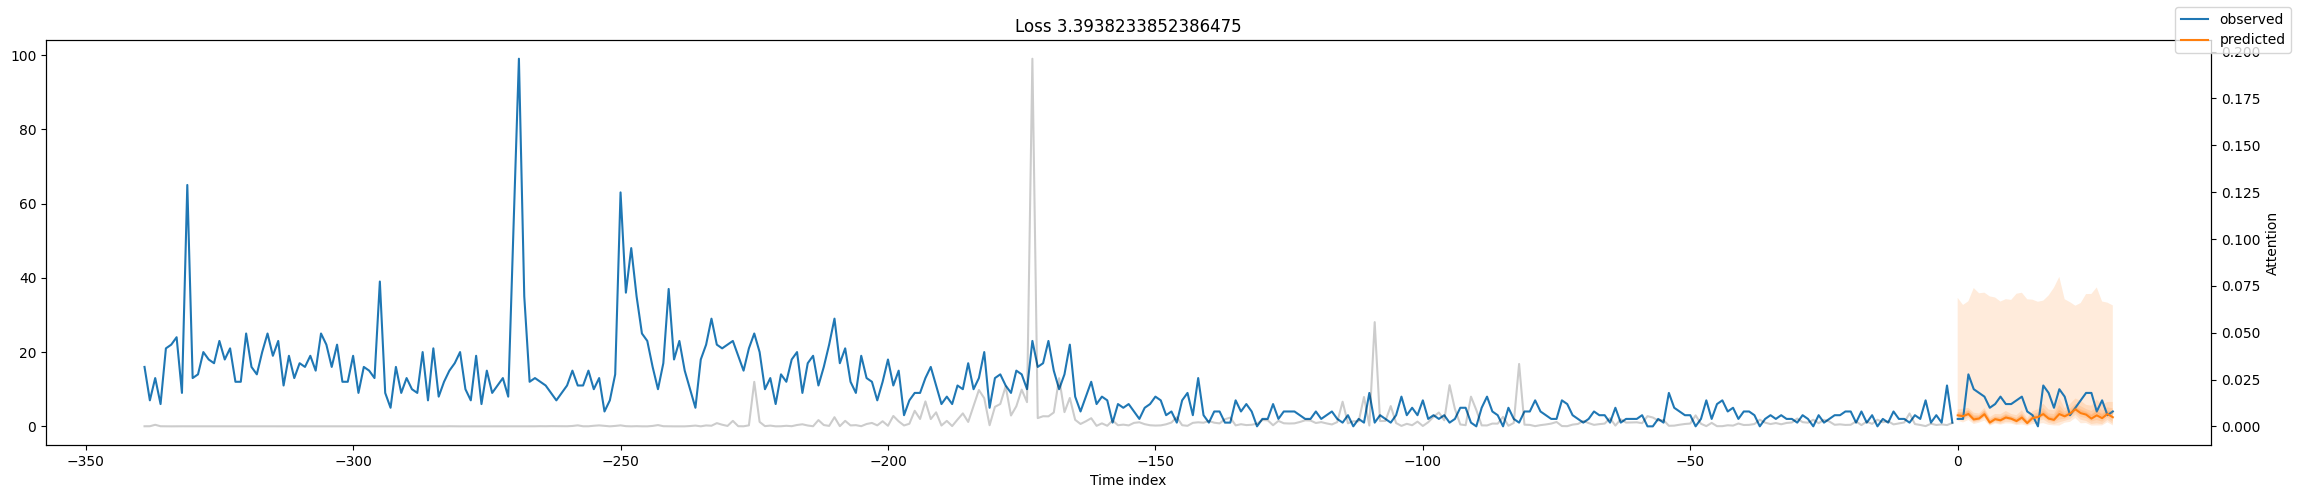

In [ ]:
for data in val_dataloader:
    x, y = data
    x = {key:val.to(device) for key, val in x.items()}
    pred = model(x)
    print(x["encoder_cont"].shape)
    print(y[0].shape)

    fig, ax = plt.subplots(figsize=(23,5))
    model.plot_prediction(x, # network input
                        pred, # network output
                        idx=25,
                        add_loss_to_title=True,
                        ax=ax)